In [ ]:
import os
import pickle
from pathlib import Path

import proplot as pplt
from matplotlib import pyplot as plt
from matplotlib.ticker import FormatStrFormatter
from proplot.axes import Axes

from evaluation.fluctuation_analysis.metrics import Metrics


In [91]:
scenario_short = {
    "CVE-2017-7529": "2017",
    "CVE-2014-0160": "2014",
    "CVE-2012-2122": "2012",
    "Bruteforce_CWE-307": "BF",
    "CWE-89-SQL-injection": "SQL",
    "SQL_Injection_CWE-89": "SQL",
    "PHP_CWE-434": "PHP",
    "CVE-2018-3760": "2018",
    "CVE-2019-5418": "2019",
    "EPS_CWE-434": "EPS",
    "Juice-Shop": "JUIC",
    "ZipSlip": "ZIP",
    "CVE-2020-23839": "CMS",
    "CVE-2020-9484": "TOM",
    "CVE-2020-13942": "UNOM",
    "CVE-2017-12635_6": "CBD",
}

dataset_short = {
    "LID-DS-2019": "19",
    "LID-DS-2021": "21",
}
BASE_PATH = "final"

plt.style.use("bmh")

plt.rcParams['axes.facecolor'] = '#f9f9f9'


In [32]:
 
configs: list[tuple] = [
    ('TF', 'LID-DS-2019', 'CVE-2017-7529', 8, 16, 2, 2, 0.1, True),
    ('TF', 'LID-DS-2021', 'Bruteforce_CWE-307', 8, 16, 2, 2, 0.1, True),
    ('TF', 'LID-DS-2019', 'CVE-2019-5418', 8, 16, 2, 2, 0.1, True),
]


In [4]:
all_metrics: dict[tuple, dict[int, Metrics]] = {}

In [5]:

def load_metrics(config, run=0):
    path = os.path.join(
        BASE_PATH,
        "metrics",
        f"run_{run}.0" if run > 0 else "",
        f"{'_'.join((str(c) for c in config))}.pickle"
    )
    # print(path)
    if config in all_metrics:
        return all_metrics[config]
    with open(path, 'rb') as f_in:
        all_metrics[config] = pickle.load(f_in)
    return all_metrics[config]

In [6]:
def early_stopping_min_or_no_improve_last_x(ths, x=10):
    ths_idx_best = 0
    x_since_best = 0
    for i, _th in enumerate(ths):
        if _th < ths[ths_idx_best]:
            ths_idx_best = i
            x_since_best = 0
        else:
            x_since_best += 1
        if x_since_best > x:
            break

    return ths_idx_best


def early_stopping_picked(_conf, _per, x=10, _train=False, _loss=False, _wait=0, run=0):
    """
    
    Returns:
        tp_ngs, fp_ngs, dr, epoch, precision, f1
    """
    metrics: list[Metrics] = list(load_metrics(_conf, run).values())
    if _loss:
        values = [_met.train_loss if _train else _met.val_loss for _met in metrics]
    else:
        values = [_met.threshold_train if _train else _met.threshold for _met in metrics]

    min_loss_idx = early_stopping_min_or_no_improve_last_x(values, x)
    min_loss_idx = min(min_loss_idx + _wait, len(metrics) - 1)
    picked = metrics[min_loss_idx]
    dr = picked.tpr[_per]
    fp_ngs = picked.fp_ngs[_per]
    tp_ngs = picked.tp_ngs[_per]
    precision = picked.precision_ngs[_per]
    f1 = picked.f1_ngs[_per]

    return tp_ngs, fp_ngs, dr, picked.epoch, precision, f1



In [7]:
for conf in configs:
    load_metrics(conf)

In [92]:
def fill_ax(_ax, epochs, detected, false_positives, detection_rates, max_detected_false, title):
    _ax.plot(
        epochs,
        detected,
        color='green',
        label='detected',
        marker="x",
        markersize=0.6,
        linestyle='-.',
        linewidth=0.3
    )
    _ax.scatter(epochs, false_positives, color='red', label='false positives', markersize=0.6, marker='o')
    ax_dr = _ax.twinx()
    ax_dr.fill_between(epochs, detection_rates, color='grey', label='detection rate', alpha=0.3, step='post')
    ax_dr.set_ylim(0, 1)
    ax_dr.set_yticks([])
    

    ax_dr.set_title(
        label=title,
        fontdict={"fontsize": 10,}
    )   
    ax_dr.format(
        titleloc="ul",
    )

    _ax.set_xlim(0, max(epochs) + 5)
    _ax.set_xticks(range(0, max(epochs) + 1, 200))
    _ax.set_yticks([0, max_detected_false])
    _ax.yaxis.set_major_formatter(FormatStrFormatter('%d'))
    _ax.xaxis.set_major_formatter(FormatStrFormatter('%d'))

    if _ax.is_first_col():
        _ax.set_ylabel("TP-NG / FP-NG", size=8)

    if _ax.is_last_col():
        # get row number 
        _ax_row_number = _ax.get_subplotspec().rowspan.start
        ax_dr.set_ylabel("DR / THR / LOSS", size=8)
        ax_dr.format(
            ylabelpad=-4,
        )
        ax_dr.set_yticks([0, 1])

    return _ax, ax_dr


def plot_detected_false_positive_detection_rate(_configs: list[tuple], ncols=3, path=None):
    THR = {"color": 'black',  "linestyle":'--', "linewidth":0.5}
    VAL = {"color": 'orange', "linestyle":'--', "linewidth":0.5}
    THRV = {"color": 'black', "linestyle":'--', "linewidth":0.9}
    VALV = {"color": 'orange', "linestyle":'--', "linewidth":0.9}
    nrows = len(_configs)
    fig, axs = pplt.subplots(
        nrows=nrows,
        ncols=ncols,
        sharex=True,
        sharey=False,
        refwidth=2.5,
        refheight=2,
        innerpad=0.05
    )
    # iterate over axs rows
    marker_size = 1
    ax_idx = 0
    x = 25
    for config in _configs:
        _ax: Axes
        _ax_rows = axs[ax_idx:ax_idx + ncols]
        _ax_rows.format(
            xlim=(0, 900),
            ylim=(-0.05, 1),
            xticks=range(0, 900, 200),
            yticks=[0, 1],
        )
        metrics = all_metrics[config].values()
        title = f"{config[0]} {dataset_short[config[1]]}-{scenario_short[config[2]]} n{config[3]} d{config[4] if config[0] == 'AE' else config[7]}"
        epochs = [_met.epoch for _met in metrics]

        train_losses = [_met.train_loss for _met in metrics]
        val_losses = [_met.val_loss for _met in metrics]
        val_loss_early_stop_idx = early_stopping_min_or_no_improve_last_x(val_losses, x)
        max_train_loss = max(train_losses)
        max_val_loss = max(val_losses)
        val_losses = [_l / max_val_loss for _l in val_losses]
        max_detected = max([_met.tp_ngs[0] for _met in metrics])
        max_false_positives = max([_met.fp_ngs[0] for _met in metrics])
        max_detected_false = max(max_detected, max_false_positives)

        _ax = _ax_rows[0]
        detected = [_met.tp_ngs[0] for _met in metrics]
        false_positives = [_met.fp_ngs[0] for _met in metrics]
        detection_rates = [_met.tpr[0] for _met in metrics]
        ths = [_met.threshold for _met in metrics]
        ths_early_stop_idx = early_stopping_min_or_no_improve_last_x(ths, x)
        max_ths = max(ths)
        ths = [_th / max_ths for _th in ths]
        ths_train = [_met.threshold_train for _met in metrics]

        _ax, ax_dr = fill_ax(_ax, epochs, detected, false_positives, detection_rates, max_detected_false, title + " (0%)")
        ax_dr.plot(epochs, ths, **THR)
        ax_dr.plot(epochs, val_losses,**VAL)
        _ax.vlines(epochs[ths_early_stop_idx], 0, max_detected_false, **THRV)
        _ax.vlines(epochs[val_loss_early_stop_idx], 0, max_detected_false, **VALV)

        _ax = _ax_rows[1]
        detected_20 = [_met.tp_ngs[20] for _met in metrics]
        false_positives_20 = [_met.fp_ngs[20] for _met in metrics]
        detection_rates_20 = [_met.tpr[20] for _met in metrics]
        _ax, ax_dr = fill_ax(_ax, epochs, detected_20, false_positives_20, detection_rates_20, max_detected_false, title + " (20%)")
        ths_20 = [_met.thr[20] for _met in metrics]
        max_ths_20 = max(ths_20)
        ths_20 = [_th / max_ths_20 for _th in ths_20]
        ax_dr.plot(epochs, ths_20, **THR)
        ax_dr.plot(epochs, val_losses,**VAL)
        _ax.vlines(epochs[ths_early_stop_idx], 0, max_detected_false, **THRV)
        _ax.vlines(epochs[val_loss_early_stop_idx], 0, max_detected_false, **VALV)
        _ax.set_yticklabels([])

        _ax = _ax_rows[2]
        detected_60 = [_met.tp_ngs[60] for _met in metrics]
        false_positives_60 = [_met.fp_ngs[60] for _met in metrics]
        detection_rates_60 = [_met.tpr[60] for _met in metrics]
        _ax, ax_dr = fill_ax(_ax, epochs, detected_60, false_positives_60, detection_rates_60, max_detected_false, title + " (60%)")
        ths_60 = [_met.thr[60] for _met in metrics]
        max_ths_60 = max(ths_60)
        ths_60 = [_th / max_ths_60 for _th in ths_60]
        ax_dr.plot(epochs, ths_60, **THR)
        ax_dr.plot(epochs, val_losses,**VAL)
        _ax.vlines(epochs[ths_early_stop_idx], 0, max_detected_false, **THRV)
        _ax.vlines(epochs[val_loss_early_stop_idx], 0, max_detected_false, **VALV)
        _ax.set_yticklabels([])

        ax_idx += ncols

    legend_entries = [
        _ax.plot(
            [],
            [],
            color='green',
            label='True Positive',
            marker="x",
            markersize=marker_size + 1,
            linestyle='--',
            linewidth=0.5
        )[0],
        _ax.scatter([], [], color='red', label='False Positives', markersize=marker_size + 1, marker='o'),
        ax_dr.fill_between([], [], color='grey', label='Detection Rate', alpha=0.4, step='post'),
        _ax.plot([], [],  label='Threshold', **THR)[0],
        _ax.plot([], [],  label='Validation Loss',**VAL)[0],
        _ax.vlines([], [], [], **VALV, label='ES-L'),
        _ax.vlines([], [], [], **THRV, label='ES-T'),
    ]
    fig.legend(
        handles=legend_entries,
        loc="b",
        frame=False,
        fontsize=8,
        ncol=5,
        pad=1,
    )

    fig.format(
        xlabel="Epochs",
        labelsize=8,
        titleloc="ul",
        ylabelpad=-10,
    )
    
    axs[1:,0].format(
        ylabelpad=-14,
    )

    if path is not None:
        Path(path).parent.mkdir(parents=True, exist_ok=True)
        fig.savefig(path, dpi=400, bbox_inches='tight')


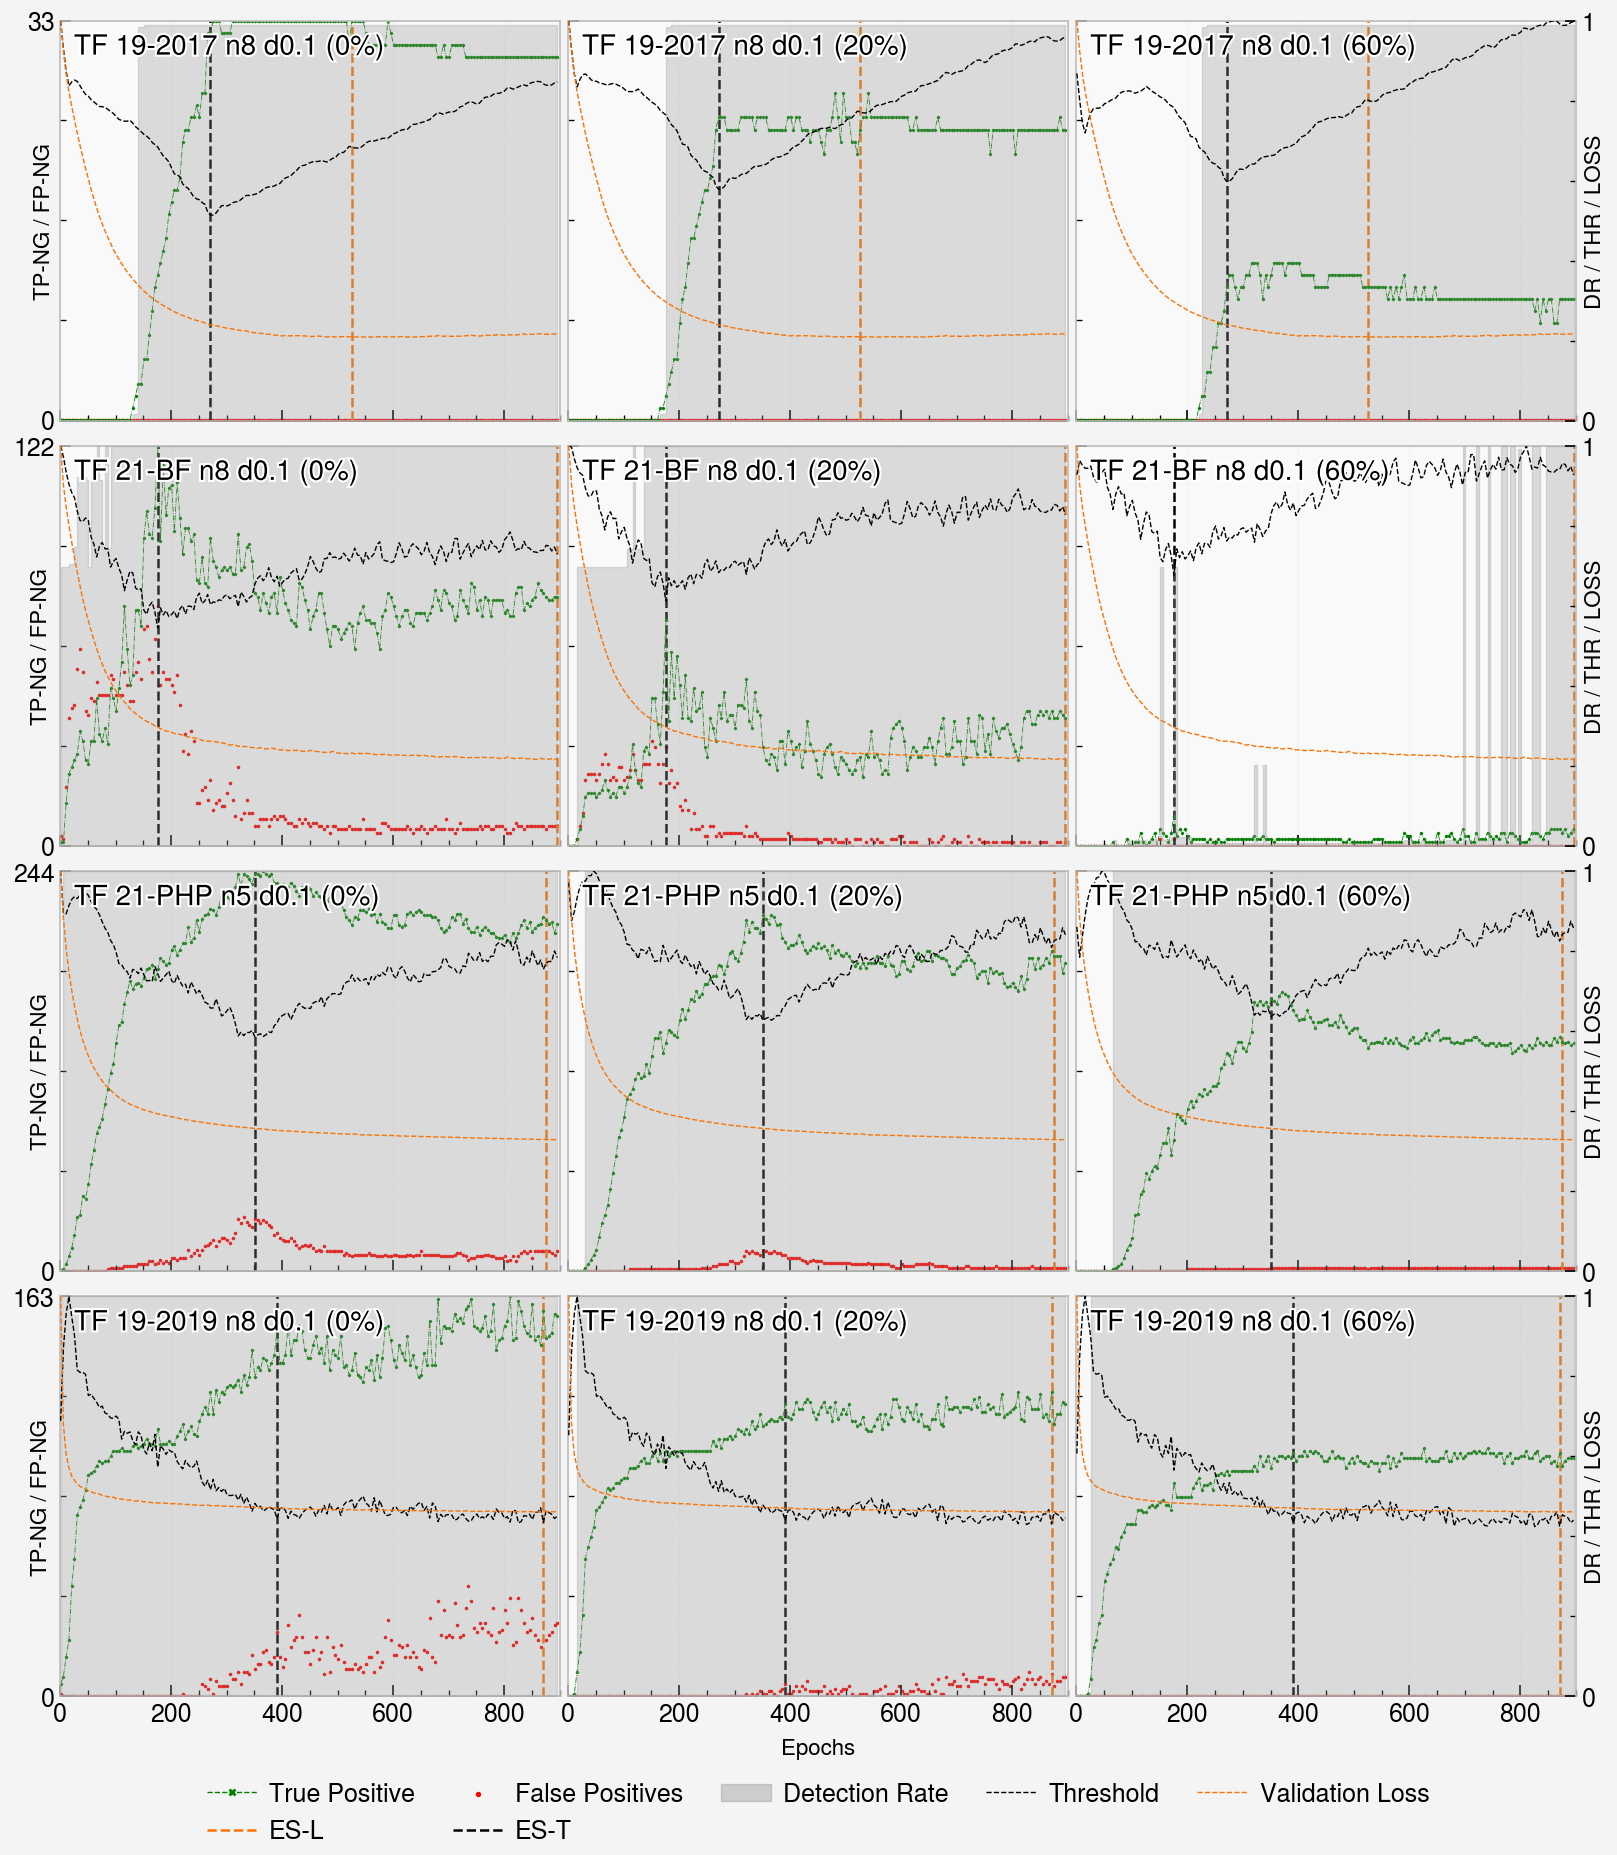

In [93]:
path = "final_plots/ths_v_loss/detected_false_counts_v_stop.png"
plot_detected_false_positive_detection_rate(configs, path=path)

# Experiments lasting 3000 epochs to make sure we are not training too short

In [23]:

configs = [
    ('TF','LID-DS-2019', 'CVE-2019-5418', 5, 16, 2, 2, 0.1, False),
    ('TF','LID-DS-2019', 'CVE-2019-5418', 8, 16, 2, 2, 0.1, True),
    ('TF','LID-DS-2019', 'SQL_Injection_CWE-89', 8, 16, 2, 2, 0.1, True),
    ('TF','LID-DS-2021', 'CVE-2020-23839', 6, 32, 4, 4, 0.1, True),
]

In [76]:
for conf in configs:
    load_metrics(conf, 69)


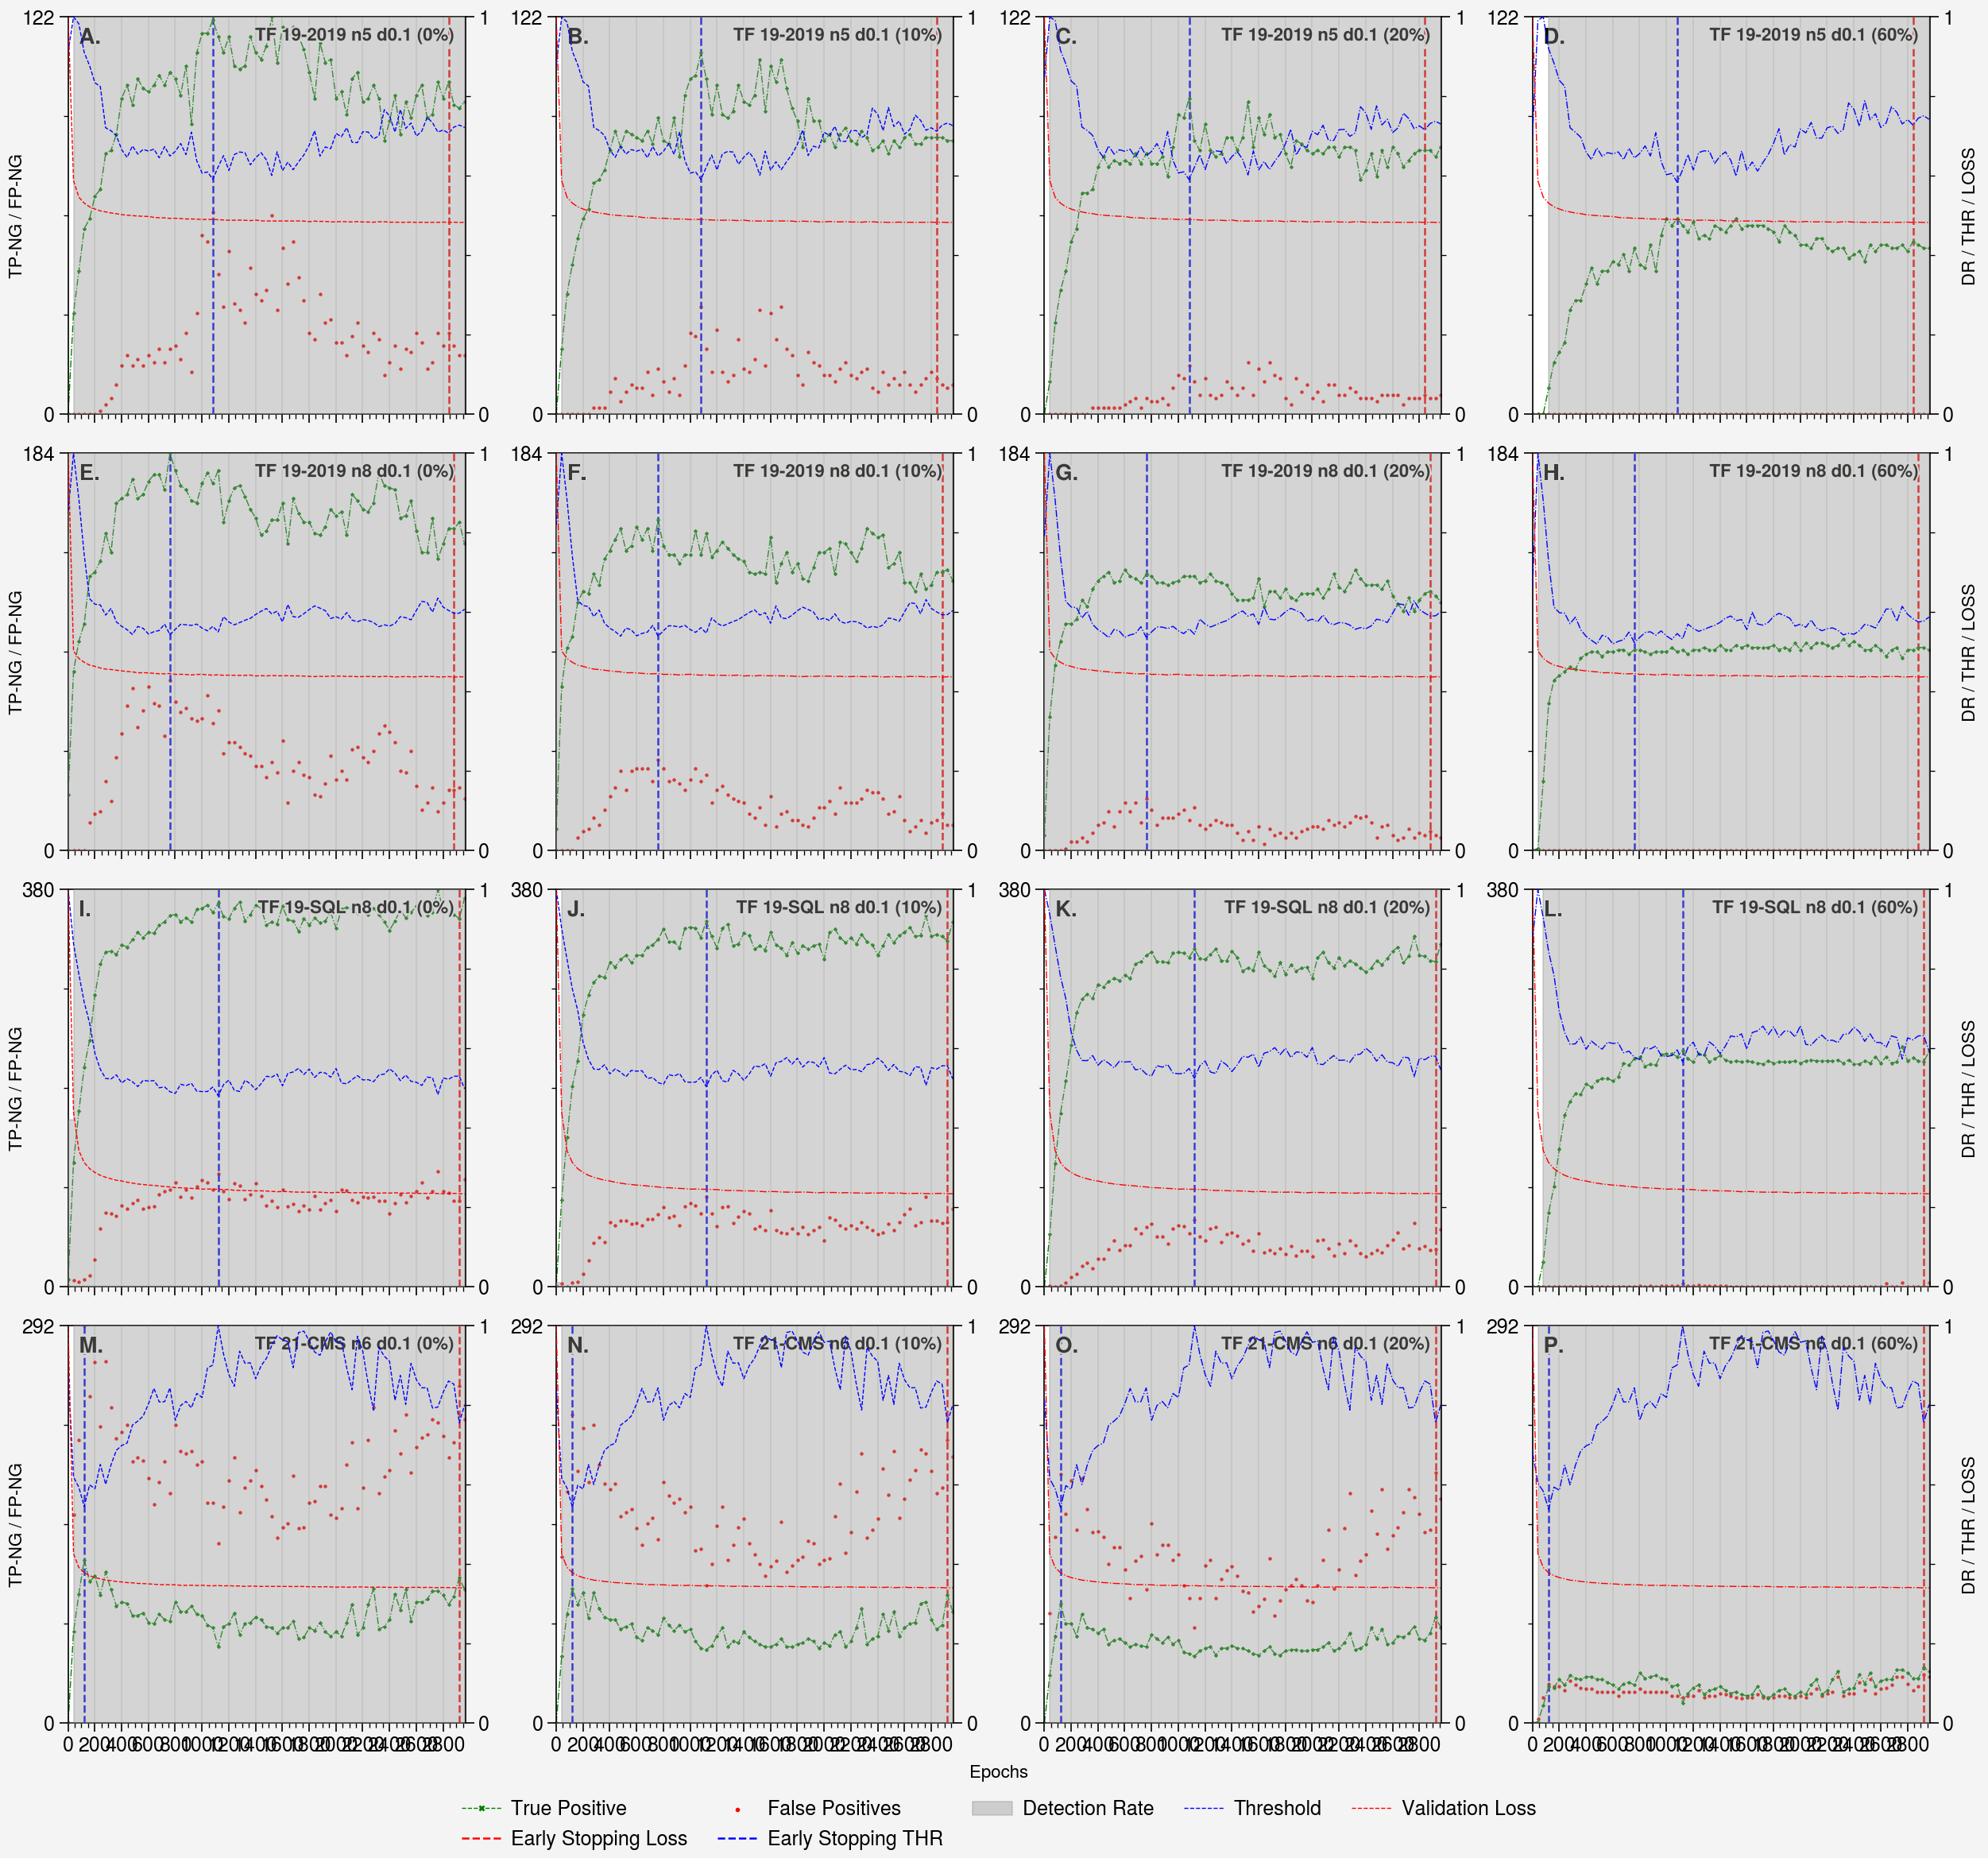

In [78]:
plot_detected_false_positive_detection_rate(configs)